# Pemodelan melibatkan udara

In [1]:
%matplotlib inline
import openmc as mc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time as tm

## Takrifan bahan

sumber = Cs-137
(1 Ci = 3.7×10$^{10}$ Bq atau 37 GBq)  

In [2]:
# 100 uCi
sourceStrength = 100e-6*(3.7e10)
sourceStrength
tenaga_foton = 661.7e3# eV - Cs137

Penyediaan nama komposis udara: N$_2$, O$_2$, Ar, CO$_2$

Pemasukan elemen bagi setiap bahan dan ketumpatan masing-masing dalam udara:  
ketumpatan udara pada 30&deg;C diambil sebagai 1.1644 g/cm$^3$:  
  
| Molekul |  mol%  |  wt%  |
|---------|:------:|:-----:|
| N      | 78.084 | 75.52 |
| O      | 20.946 | 23.14 |
| Ar      | 0.934  | 1.29  |
| CO$_2$      | 0.033  | 0.051  |

In [3]:
# Molecular weight of elements/compounds in air
mw = {'N':14.007,'O':15.999,'Ar':39.948,'C':12.011}
airMolRatio = {'N2':0.78084,'O2':0.20946+(0.00033),'Ar':0.00934,'C':0.00033}
airMolRatioAt = {'N':2*0.78084,'O':2*(0.20946+(0.00033)),'Ar':1*0.00934,'C':1*0.00033}

In [4]:
airMolRatio['O2']

0.20979

In [5]:
# for one mole
for i,j in enumerate(mw):
    print (j,'\t',mw[j])

N 	 14.007
O 	 15.999
Ar 	 39.948
C 	 12.011


In [6]:
# element weight in one mole
totalAtom = 0
for i,j in enumerate(airMolRatioAt):
    print (j,'\t',airMolRatioAt[j])
    totalAtom = totalAtom+airMolRatioAt[j]
    
print ('total atomic no: ', totalAtom,'\n')

print ('atomic wt%:')
for i,j in enumerate(airMolRatioAt):
    print (j,'\t',airMolRatioAt[j]/totalAtom)


N 	 1.56168
O 	 0.41958
Ar 	 0.00934
C 	 0.00033
total atomic no:  1.9909299999999999 

atomic wt%:
N 	 0.7843972414901579
O 	 0.21074573189413995
Ar 	 0.004691274931815785
C 	 0.00016575168388642495


In [7]:
# udara luar
udara=mc.Material(material_id=1,name='komposisi udara')

udara.add_element(element='N',percent=0.784397,percent_type='ao')
udara.add_element(element='O',percent=0.210746,percent_type='ao')
udara.add_element(element='Ar',percent=0.004691,percent_type='ao')
udara.add_element(element='C',percent=0.000166,percent_type='ao')

udara.set_density('g/cm3',0.0011644) 
udara.temperature=300.0
udara

Material
	ID             =	1
	Name           =	komposisi udara
	Temperature    =	300.0
	Density        =	0.0011644 [g/cm3]
	S(a,b) Tables  
	Nuclides       
	N14            =	0.7815237537890001 [ao]
	N15            =	0.002873246211 [ao]
	O16            =	0.21066612726599998 [ao]
	O17            =	7.987273399999999e-05 [ao]
	Ar36           =	1.5649176e-05 [ao]
	Ar38           =	2.9506389999999998e-06 [ao]
	Ar40           =	0.004672400185 [ao]
	C0             =	0.000166     [ao]

In [8]:
pb = mc.Material(material_id=2,name="Pb") # (id,nama)
pb.add_element('Pb',percent=1.0,percent_type='ao')
pb.set_density('g/cm3', 11.29)
pb.temperature=300
pb

Material
	ID             =	2
	Name           =	Pb
	Temperature    =	300
	Density        =	11.29 [g/cm3]
	S(a,b) Tables  
	Nuclides       
	Pb204          =	0.014        [ao]
	Pb206          =	0.241        [ao]
	Pb207          =	0.221        [ao]
	Pb208          =	0.524        [ao]

Pewakilan bahan-bahan kepada fail materials.xml

In [9]:
materials = mc.Materials([udara, pb])
materials.export_to_xml()
!cat materials.xml

<?xml version='1.0' encoding='utf-8'?>
<materials>
  <material id="1" name="komposisi udara" temperature="300.0">
    <density units="g/cm3" value="0.0011644" />
    <nuclide ao="0.7815237537890001" name="N14" />
    <nuclide ao="0.002873246211" name="N15" />
    <nuclide ao="0.21066612726599998" name="O16" />
    <nuclide ao="7.987273399999999e-05" name="O17" />
    <nuclide ao="1.5649176e-05" name="Ar36" />
    <nuclide ao="2.9506389999999998e-06" name="Ar38" />
    <nuclide ao="0.004672400185" name="Ar40" />
    <nuclide ao="0.000166" name="C0" />
  </material>
  <material id="2" name="Pb" temperature="300">
    <density units="g/cm3" value="11.29" />
    <nuclide ao="0.014" name="Pb204" />
    <nuclide ao="0.241" name="Pb206" />
    <nuclide ao="0.221" name="Pb207" />
    <nuclide ao="0.524" name="Pb208" />
  </material>
</materials>


## Takrifan geometri

In [10]:
# Struktur kotak (xmin, xmax, ymin, ymax, zmin, zmax)
# saiz trajektori (5 cm x 5 cm x 50 cm)
boxPb = mc.model.RectangularParallelepiped(-0.4,0.4,
                                         -0.4,0.4,
                                         -1.5,1.5, boundary_type='transmission')
boxUdara = mc.model.RectangularParallelepiped(-0.5,0.5,
                                         -0.5,0.5,
                                         -2.5,2.5, boundary_type='vacuum')

In [11]:
wilayahPb = -boxPb

In [12]:
wilayahUdara = -boxUdara & +boxPb

In [13]:
wilayahPb.bounding_box

(array([-0.4, -0.4, -1.5]), array([0.4, 0.4, 1.5]))

In [14]:
wilayahUdara.bounding_box

(array([-0.5, -0.5, -2.5]), array([0.5, 0.5, 2.5]))

## Takrif kandungan

In [15]:
kandunganUdara= mc.Cell(fill=udara, region=wilayahUdara) # Silikon sebagai medium
kandunganPb = mc.Cell(fill=pb, region=wilayahPb) # Silikon sebagai medium

In [16]:
# masukkan kandungan ke dalam Universe iaitu ruang yang merangkumi semua cell
alamsemesta = mc.Universe(cells=[kandunganUdara, kandunganPb])
geom=mc.Geometry(alamsemesta)
geom.export_to_xml()
!cat geometry.xml

<?xml version='1.0' encoding='utf-8'?>
<geometry>
  <cell id="1" material="1" region="7 -8 9 -10 11 -12 (-1 | 2 | -3 | 4 | -5 | 6)" universe="1" />
  <cell id="2" material="2" region="1 -2 3 -4 5 -6" universe="1" />
  <surface coeffs="-0.4" id="1" type="x-plane" />
  <surface coeffs="0.4" id="2" type="x-plane" />
  <surface coeffs="-0.4" id="3" type="y-plane" />
  <surface coeffs="0.4" id="4" type="y-plane" />
  <surface coeffs="-1.5" id="5" type="z-plane" />
  <surface coeffs="1.5" id="6" type="z-plane" />
  <surface boundary="vacuum" coeffs="-0.5" id="7" type="x-plane" />
  <surface boundary="vacuum" coeffs="0.5" id="8" type="x-plane" />
  <surface boundary="vacuum" coeffs="-0.5" id="9" type="y-plane" />
  <surface boundary="vacuum" coeffs="0.5" id="10" type="y-plane" />
  <surface boundary="vacuum" coeffs="-2.5" id="11" type="z-plane" />
  <surface boundary="vacuum" coeffs="2.5" id="12" type="z-plane" />
</geometry>


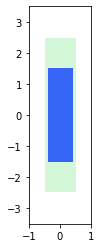

In [17]:
# lihat rupabentuk
alamsemesta.plot(origin=(0,0,0.0), width=(2,7), basis='yz', color_by='cell')

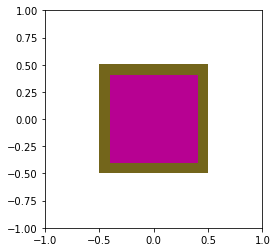

In [18]:
# lihat rupabentuk
alamsemesta.plot(origin=(0,0,0.0), width=(2,2), basis='xy', color_by='cell')

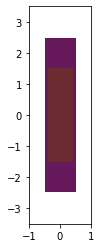

In [19]:
# lihat rupabentuk
alamsemesta.plot(origin=(0,0,0.0), width=(2,7), basis='xz', color_by='cell')

In [20]:
## Sumber radiasi satu titik
#tetapan = mc.Settings()

titik_radiasi = (0.0,0.0,-1.6)
taburan_tenaga = mc.stats.Discrete([tenaga_foton],[1.0])
taburan_ruang = mc.stats.Point(xyz=titik_radiasi)
punca = mc.Source(space=taburan_ruang,energy=taburan_tenaga,
                  particle='photon',strength=sourceStrength)

tetapan = mc.Settings()
tetapan.run_mode = 'fixed source'

tetapan.source = punca
tetapan.batches = 1000
tetapan.inactive = 100
tetapan.particles = 100000

tetapan.export_to_xml()
! cat settings.xml

<?xml version='1.0' encoding='utf-8'?>
<settings>
  <run_mode>fixed source</run_mode>
  <particles>100000</particles>
  <batches>1000</batches>
  <inactive>100</inactive>
  <source particle="photon" strength="3700000.0">
    <space type="point">
      <parameters>0.0 0.0 -1.6</parameters>
    </space>
    <energy type="discrete">
      <parameters>661700.0 1.0</parameters>
    </energy>
  </source>
</settings>


In [21]:
bin_initiate = np.linspace(0,67,68)*10000
bin_initiate

array([     0.,  10000.,  20000.,  30000.,  40000.,  50000.,  60000.,
        70000.,  80000.,  90000., 100000., 110000., 120000., 130000.,
       140000., 150000., 160000., 170000., 180000., 190000., 200000.,
       210000., 220000., 230000., 240000., 250000., 260000., 270000.,
       280000., 290000., 300000., 310000., 320000., 330000., 340000.,
       350000., 360000., 370000., 380000., 390000., 400000., 410000.,
       420000., 430000., 440000., 450000., 460000., 470000., 480000.,
       490000., 500000., 510000., 520000., 530000., 540000., 550000.,
       560000., 570000., 580000., 590000., 600000., 610000., 620000.,
       630000., 640000., 650000., 660000., 670000.])

In [22]:
# Tallies
tf=mc.Tallies()

# mesh filters
jaring=mc.RegularMesh()
jaring.dimension=[10,10,50]

jaring.lower_left=[-0.5,-0.5,-2.5]
jaring.upper_right=[0.5,0.5,2.5]

tapis_jaring=mc.MeshFilter(jaring)

# tapis tenaga
'''bin_tenaga=np.array([0.0,2.0,4.0,6.0,8.0,
            10.0,12.0,14.0,16.0,18.0,
            20.0,22.0,24.0,26.0,28.0,
            30.0,32.0,34.0,36.0,38.0,
            40.0,42.0,44.0,46.0,48.0,
            50.0,52.0,54.0,56.0,58.0,
            60.0,62.0,64.0,66.0,68.0])*10000'''

#bin_tenaga = np.linspace(0,68,35)*10000
bin_tenaga = np.linspace(0,67,68)*10000


tapis_tenaga=mc.EnergyFilter(bin_tenaga)

tally1=mc.Tally(name="flux mesh")
tally1.filters=[tapis_jaring,tapis_tenaga]

tally1.scores=['flux']
tf.append(tally1)

'''
bin_tenagaPeak=np.array([66.169,66.171])*10000

tapis_tenagaPeak=mc.EnergyFilter(bin_tenagaPeak)

tally2=mc.Tally(name="flux mesh")
tally2.filters=[tapis_jaring,tapis_tenagaPeak]

tally2.scores=['flux']
tf.append(tally2)'''

tf.export_to_xml()
! cat settings.xml

<?xml version='1.0' encoding='utf-8'?>
<settings>
  <run_mode>fixed source</run_mode>
  <particles>100000</particles>
  <batches>1000</batches>
  <inactive>100</inactive>
  <source particle="photon" strength="3700000.0">
    <space type="point">
      <parameters>0.0 0.0 -1.6</parameters>
    </space>
    <energy type="discrete">
      <parameters>661700.0 1.0</parameters>
    </energy>
  </source>
</settings>


In [23]:
start = tm.time()
runData = mc.run()
stop = tm.time()
print ('time : ', (stop-start)/60, ' min')


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Simulating batch 206
 Simulating batch 207
 Simulating batch 208
 Simulating batch 209
 Simulating batch 210
 Simulating batch 211
 Simulating batch 212
 Simulating batch 213
 Simulating batch 214
 Simulating batch 215
 Simulating batch 216
 Simulating batch 217
 Simulating batch 218
 Simulating batch 219
 Simulating batch 220
 Simulating batch 221
 Simulating batch 222
 Simulating batch 223
 Simulating batch 224
 Simulating batch 225
 Simulating batch 226
 Simulating batch 227
 Simulating batch 228
 Simulating batch 229
 Simulating batch 230
 Simulating batch 231
 Simulating batch 232
 Simulating batch 233
 Simulating batch 234
 Simulating batch 235
 Simulating batch 236
 Simulating batch 237
 Simulating batch 238
 Simulating batch 239
 Simulating batch 240
 Simulating batch 241
 Simulating batch 242
 Simulating batch 243
 Simulating batch 244
 Simulating batch 245
 Simulating batch 246
 Simulating batch 247
 Simulating batch 248
 Simulating batch 249
 Simulating batch 250
 Simulatin

 Simulating batch 579
 Simulating batch 580
 Simulating batch 581
 Simulating batch 582
 Simulating batch 583
 Simulating batch 584
 Simulating batch 585
 Simulating batch 586
 Simulating batch 587
 Simulating batch 588
 Simulating batch 589
 Simulating batch 590
 Simulating batch 591
 Simulating batch 592
 Simulating batch 593
 Simulating batch 594
 Simulating batch 595
 Simulating batch 596
 Simulating batch 597
 Simulating batch 598
 Simulating batch 599
 Simulating batch 600
 Simulating batch 601
 Simulating batch 602
 Simulating batch 603
 Simulating batch 604
 Simulating batch 605
 Simulating batch 606
 Simulating batch 607
 Simulating batch 608
 Simulating batch 609
 Simulating batch 610
 Simulating batch 611
 Simulating batch 612
 Simulating batch 613
 Simulating batch 614
 Simulating batch 615
 Simulating batch 616
 Simulating batch 617
 Simulating batch 618
 Simulating batch 619
 Simulating batch 620
 Simulating batch 621
 Simulating batch 622
 Simulating batch 623
 Simulatin

 Simulating batch 952
 Simulating batch 953
 Simulating batch 954
 Simulating batch 955
 Simulating batch 956
 Simulating batch 957
 Simulating batch 958
 Simulating batch 959
 Simulating batch 960
 Simulating batch 961
 Simulating batch 962
 Simulating batch 963
 Simulating batch 964
 Simulating batch 965
 Simulating batch 966
 Simulating batch 967
 Simulating batch 968
 Simulating batch 969
 Simulating batch 970
 Simulating batch 971
 Simulating batch 972
 Simulating batch 973
 Simulating batch 974
 Simulating batch 975
 Simulating batch 976
 Simulating batch 977
 Simulating batch 978
 Simulating batch 979
 Simulating batch 980
 Simulating batch 981
 Simulating batch 982
 Simulating batch 983
 Simulating batch 984
 Simulating batch 985
 Simulating batch 986
 Simulating batch 987
 Simulating batch 988
 Simulating batch 989
 Simulating batch 990
 Simulating batch 991
 Simulating batch 992
 Simulating batch 993
 Simulating batch 994
 Simulating batch 995
 Simulating batch 996
 Simulatin

In [24]:
%%bash
cp statepoint.1000.h5 Pb_detector_cs_137.h5

In [25]:
# Load the statepoint file
sp = mc.StatePoint('Pb_detector_cs_137.h5')

In [26]:
ekorCs137 = sp.get_tally()
ekorCs137

Tally
	ID             =	1
	Name           =	flux mesh
	Filters        =	MeshFilter, EnergyFilter
	Nuclides       =	total
	Scores         =	['flux']
	Estimator      =	tracklength

In [27]:
dfCs137 = ekorCs137.get_pandas_dataframe()
dfCs137

mesh 1         energy low [eV] energy high [eV] nuclide score     mean  \
            x   y   z                                                           
0           1   1   1        0.00e+00         1.00e+04   total  flux 0.00e+00   
1           1   1   1        1.00e+04         2.00e+04   total  flux 5.79e-02   
2           1   1   1        2.00e+04         3.00e+04   total  flux 3.61e-03   
3           1   1   1        3.00e+04         4.00e+04   total  flux 0.00e+00   
4           1   1   1        4.00e+04         5.00e+04   total  flux 0.00e+00   
...       ...  ..  ..             ...              ...     ...   ...      ...   
334995     10  10  50        6.20e+05         6.30e+05   total  flux 7.16e-03   
334996     10  10  50        6.30e+05         6.40e+05   total  flux 2.61e-02   
334997     10  10  50        6.40e+05         6.50e+05   total  flux 1.79e-02   
334998     10  10  50        6.50e+05         6.60e+05   total  flux 2.29e-02   
334999     10  10  50        6.60e+05         6.70e+05   total  flux 5.30e-01   

       std. dev.  
                  
0       0.00e+00  
1       1.37e-02  
2       3.61e-03  
3       0.00e+00  
4       0.00e+00  
...          ...  
334995  4.45e-03  
334996  9.62e-03  
334997  7.83e-03  
334998  8.22e-03  
334999  4.23e-02  

[335000 rows x 9 columns]

In [35]:
chName = np.linspace(1,67,67).astype('str')

chDataFrame = dict.fromkeys(chName,0)

In [36]:
chDataFrame

{'1.0': 0,
 '2.0': 0,
 '3.0': 0,
 '4.0': 0,
 '5.0': 0,
 '6.0': 0,
 '7.0': 0,
 '8.0': 0,
 '9.0': 0,
 '10.0': 0,
 '11.0': 0,
 '12.0': 0,
 '13.0': 0,
 '14.0': 0,
 '15.0': 0,
 '16.0': 0,
 '17.0': 0,
 '18.0': 0,
 '19.0': 0,
 '20.0': 0,
 '21.0': 0,
 '22.0': 0,
 '23.0': 0,
 '24.0': 0,
 '25.0': 0,
 '26.0': 0,
 '27.0': 0,
 '28.0': 0,
 '29.0': 0,
 '30.0': 0,
 '31.0': 0,
 '32.0': 0,
 '33.0': 0,
 '34.0': 0,
 '35.0': 0,
 '36.0': 0,
 '37.0': 0,
 '38.0': 0,
 '39.0': 0,
 '40.0': 0,
 '41.0': 0,
 '42.0': 0,
 '43.0': 0,
 '44.0': 0,
 '45.0': 0,
 '46.0': 0,
 '47.0': 0,
 '48.0': 0,
 '49.0': 0,
 '50.0': 0,
 '51.0': 0,
 '52.0': 0,
 '53.0': 0,
 '54.0': 0,
 '55.0': 0,
 '56.0': 0,
 '57.0': 0,
 '58.0': 0,
 '59.0': 0,
 '60.0': 0,
 '61.0': 0,
 '62.0': 0,
 '63.0': 0,
 '64.0': 0,
 '65.0': 0,
 '66.0': 0,
 '67.0': 0}

In [37]:
incrLV = 0.0
incrUP = 10000.0 # eV

for i, j in enumerate(chDataFrame):
    print (j,incrLV,incrUP)
    chDataFrame[j]=dfCs137.loc[(dfCs137['energy low [eV]'] == incrLV) & (dfCs137['energy high [eV]'] == incrUP)]
    incrLV = incrLV+10000.0
    incrUP = incrUP+10000.0

1.0 0.0 10000.0
2.0 10000.0 20000.0
3.0 20000.0 30000.0
4.0 30000.0 40000.0
5.0 40000.0 50000.0
6.0 50000.0 60000.0
7.0 60000.0 70000.0
8.0 70000.0 80000.0
9.0 80000.0 90000.0
10.0 90000.0 100000.0
11.0 100000.0 110000.0
12.0 110000.0 120000.0
13.0 120000.0 130000.0
14.0 130000.0 140000.0
15.0 140000.0 150000.0
16.0 150000.0 160000.0
17.0 160000.0 170000.0
18.0 170000.0 180000.0
19.0 180000.0 190000.0
20.0 190000.0 200000.0
21.0 200000.0 210000.0
22.0 210000.0 220000.0
23.0 220000.0 230000.0
24.0 230000.0 240000.0
25.0 240000.0 250000.0
26.0 250000.0 260000.0
27.0 260000.0 270000.0
28.0 270000.0 280000.0
29.0 280000.0 290000.0
30.0 290000.0 300000.0
31.0 300000.0 310000.0
32.0 310000.0 320000.0
33.0 320000.0 330000.0
34.0 330000.0 340000.0
35.0 340000.0 350000.0
36.0 350000.0 360000.0
37.0 360000.0 370000.0
38.0 370000.0 380000.0
39.0 380000.0 390000.0
40.0 390000.0 400000.0
41.0 400000.0 410000.0
42.0 410000.0 420000.0
43.0 420000.0 430000.0
44.0 430000.0 440000.0
45.0 440000.0 450000

In [38]:
chDataFrame['67.0']

mesh 1         energy low [eV] energy high [eV] nuclide score  \
            x   y   z                                                  
66          1   1   1        660000.0         670000.0   total  flux   
133         2   1   1        660000.0         670000.0   total  flux   
200         3   1   1        660000.0         670000.0   total  flux   
267         4   1   1        660000.0         670000.0   total  flux   
334         5   1   1        660000.0         670000.0   total  flux   
...       ...  ..  ..             ...              ...     ...   ...   
334731      6  10  50        660000.0         670000.0   total  flux   
334798      7  10  50        660000.0         670000.0   total  flux   
334865      8  10  50        660000.0         670000.0   total  flux   
334932      9  10  50        660000.0         670000.0   total  flux   
334999     10  10  50        660000.0         670000.0   total  flux   

              mean std. dev.  
                              
66      260.197153  0.923592  
133     280.755341  0.935666  
200     299.165797  1.044236  
267     309.692421  1.011779  
334     319.066234  1.058774  
...            ...       ...  
334731    0.474120  0.043379  
334798    0.550195  0.044914  
334865    0.616594  0.046523  
334932    0.499733  0.042226  
334999    0.530041  0.042277  

[5000 rows x 9 columns]

In [39]:
# Creating new dictionary template for spectrum values for each individual mesh
chDataFrameMean = dict.fromkeys(chName,0)

In [40]:
# Inserting spectrum
for i, j in enumerate(chDataFrameMean):
        chDataFrameMean[j]=chDataFrame[j]['mean'].values.reshape((50,10,10))
        print (i,chDataFrameMean[j].shape)

0 (50, 10, 10)
1 (50, 10, 10)
2 (50, 10, 10)
3 (50, 10, 10)
4 (50, 10, 10)
5 (50, 10, 10)
6 (50, 10, 10)
7 (50, 10, 10)
8 (50, 10, 10)
9 (50, 10, 10)
10 (50, 10, 10)
11 (50, 10, 10)
12 (50, 10, 10)
13 (50, 10, 10)
14 (50, 10, 10)
15 (50, 10, 10)
16 (50, 10, 10)
17 (50, 10, 10)
18 (50, 10, 10)
19 (50, 10, 10)
20 (50, 10, 10)
21 (50, 10, 10)
22 (50, 10, 10)
23 (50, 10, 10)
24 (50, 10, 10)
25 (50, 10, 10)
26 (50, 10, 10)
27 (50, 10, 10)
28 (50, 10, 10)
29 (50, 10, 10)
30 (50, 10, 10)
31 (50, 10, 10)
32 (50, 10, 10)
33 (50, 10, 10)
34 (50, 10, 10)
35 (50, 10, 10)
36 (50, 10, 10)
37 (50, 10, 10)
38 (50, 10, 10)
39 (50, 10, 10)
40 (50, 10, 10)
41 (50, 10, 10)
42 (50, 10, 10)
43 (50, 10, 10)
44 (50, 10, 10)
45 (50, 10, 10)
46 (50, 10, 10)
47 (50, 10, 10)
48 (50, 10, 10)
49 (50, 10, 10)
50 (50, 10, 10)
51 (50, 10, 10)
52 (50, 10, 10)
53 (50, 10, 10)
54 (50, 10, 10)
55 (50, 10, 10)
56 (50, 10, 10)
57 (50, 10, 10)
58 (50, 10, 10)
59 (50, 10, 10)
60 (50, 10, 10)
61 (50, 10, 10)
62 (50, 10, 10)
63

In [41]:
chDataFrameMean['60.0']

array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         2.02800462e-05, 0.00000000e+00, 0.00000000e+00],
        ...,
        [1.22563628e-05, 3.73611365e-03, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 4.19575757e-03],
        [3.65589769e-04, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 4.26853016e-03],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 2.04740537e-03, 1.21687677e-03]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 

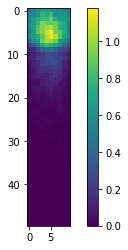

In [42]:
# parameters: energy 1000eV and postion 0 on z-axis
plt.imshow(chDataFrameMean['20.0'][:,9,:]);
plt.colorbar()


28.009307728017333


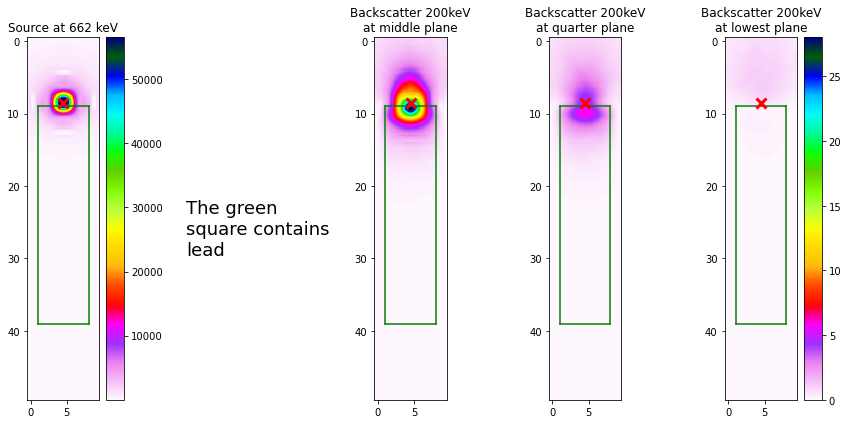

In [43]:
backvmax = chDataFrameMean['20.0'][:,:,4].max()
print (backvmax)
fig = plt.figure(figsize=(12, 6))

#fig, ax = plt.subplots(1, 4)

ax0 = fig.add_subplot(1, 5, 1)
ax0.title.set_text('Source at 662 keV')
source = ax0.imshow((chDataFrameMean['67.0'][:,:,4]),
                      cmap='gist_ncar_r',interpolation='bessel');
ax0.plot([1,8],[9,9],'g')
ax0.plot([1,8],[39,39],'g')
ax0.plot([1,1],[9,39],'g')
ax0.plot([8,8],[9,39],'g')
ax0.plot([4.5],[8.5],'rx',ms=10,markeredgewidth=3)
fig.colorbar(source,ax=ax0)

text0 = fig.add_subplot(1, 5, 2)

text0.xaxis.set_visible(False)
text0.yaxis.set_visible(False)
for spine in ['top', 'right', 'left', 'bottom']:
    text0.spines[spine].set_visible(False)

text0.text(0.1,0.4,'The green\nsquare contains\nlead', fontsize=18)

ax1 = fig.add_subplot(1, 5, 3)
ax1.title.set_text('Backscatter 200keV\nat middle plane')
backscatter = ax1.imshow((chDataFrameMean['20.0'][:,:,4]),vmax = backvmax,
                           cmap='gist_ncar_r',interpolation='bessel');
ax1.plot([1,8],[9,9],'g')
ax1.plot([1,8],[39,39],'g')
ax1.plot([1,1],[9,39],'g')
ax1.plot([8,8],[9,39],'g')
ax1.plot([4.5],[8.5],'rx',ms=10,markeredgewidth=3)
#fig.colorbar(backscatter,ax=ax1)



ax2 = fig.add_subplot(1, 5, 4)
ax2.title.set_text('Backscatter 200keV\nat quarter plane')
backscatter = ax2.imshow((chDataFrameMean['20.0'][:,:,2]),vmax = backvmax,
                           cmap='gist_ncar_r',interpolation='bessel');
ax2.plot([1,8],[9,9],'g')
ax2.plot([1,8],[39,39],'g')
ax2.plot([1,1],[9,39],'g')
ax2.plot([8,8],[9,39],'g')
ax2.plot([4.5],[8.5],'rx',ms=10,markeredgewidth=3)
#fig.colorbar(backscatter,ax=ax[2])

ax3 = fig.add_subplot(1, 5, 5)
ax3.title.set_text('Backscatter 200keV\nat lowest plane')
backscatter = ax3.imshow((chDataFrameMean['20.0'][:,:,0]),vmax = backvmax,
                           cmap='gist_ncar_r',interpolation='bessel');
ax3.plot([1,8],[9,9],'g')
ax3.plot([1,8],[39,39],'g')
ax3.plot([1,1],[9,39],'g')
ax3.plot([8,8],[9,39],'g')
ax3.plot([4.5],[8.5],'rx',ms=10,markeredgewidth=3)
fig.colorbar(backscatter,ax=ax3)

plt.tight_layout()
plt.savefig('backscatter_Pb.jpeg')

In [44]:
# Creating new dictionary (layerSpectr) template for sum of spectrum values for each slice in z-axis
layer = np.arange(50)
layerSpectr = dict.fromkeys(layer,0)
layerSpectr

{0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0,
 15: 0,
 16: 0,
 17: 0,
 18: 0,
 19: 0,
 20: 0,
 21: 0,
 22: 0,
 23: 0,
 24: 0,
 25: 0,
 26: 0,
 27: 0,
 28: 0,
 29: 0,
 30: 0,
 31: 0,
 32: 0,
 33: 0,
 34: 0,
 35: 0,
 36: 0,
 37: 0,
 38: 0,
 39: 0,
 40: 0,
 41: 0,
 42: 0,
 43: 0,
 44: 0,
 45: 0,
 46: 0,
 47: 0,
 48: 0,
 49: 0}

In [130]:
# Inserting spectrum in layerSpectr
layer = np.arange(50)
layerSpectr = dict.fromkeys(layer,0)

for i,j in enumerate(layer):
    spectr = []
    for m,n in enumerate(chDataFrameMean):

        spectr = spectr+[np.sum(chDataFrameMean[n][j,1:9,1:9])]
        
    layerSpectr[j]=spectr

In [131]:
# Example building x-axis array for bar chart
xEnergy = np.repeat(np.linspace(0,670000,68),2)
xEnergy

array([     0.,      0.,  10000.,  10000.,  20000.,  20000.,  30000.,
        30000.,  40000.,  40000.,  50000.,  50000.,  60000.,  60000.,
        70000.,  70000.,  80000.,  80000.,  90000.,  90000., 100000.,
       100000., 110000., 110000., 120000., 120000., 130000., 130000.,
       140000., 140000., 150000., 150000., 160000., 160000., 170000.,
       170000., 180000., 180000., 190000., 190000., 200000., 200000.,
       210000., 210000., 220000., 220000., 230000., 230000., 240000.,
       240000., 250000., 250000., 260000., 260000., 270000., 270000.,
       280000., 280000., 290000., 290000., 300000., 300000., 310000.,
       310000., 320000., 320000., 330000., 330000., 340000., 340000.,
       350000., 350000., 360000., 360000., 370000., 370000., 380000.,
       380000., 390000., 390000., 400000., 400000., 410000., 410000.,
       420000., 420000., 430000., 430000., 440000., 440000., 450000.,
       450000., 460000., 460000., 470000., 470000., 480000., 480000.,
       490000., 4900

In [132]:
layerSpectr[0]

[0.23229657891099584,
 4.641784956468201,
 0.11194237589904577,
 0.2376604727131999,
 0.3398452727799568,
 0.8032984973699759,
 2.5956642889605717,
 156.7649971202199,
 57.43067901439992,
 0.2449850617254833,
 0.3502692868385072,
 0.44037840423593505,
 0.6074608621107196,
 1.0917916981471434,
 1.907543831499225,
 3.1695612840303635,
 5.490090565151599,
 10.265620045440604,
 31.523460759313952,
 53.751586853284465,
 54.40180053447773,
 44.442232706256746,
 31.95414858332838,
 21.172948610773595,
 12.965446293157118,
 7.132987341600977,
 4.4942655819206125,
 2.9470050268806407,
 1.9945740162238514,
 1.331594259985916,
 1.2139437897243948,
 0.921984081218845,
 0.6150852610268871,
 0.5228770348919884,
 0.5375242458168704,
 0.46996285471042687,
 0.3825794573158319,
 0.35995400026650376,
 0.29210674694429856,
 0.3182204045607018,
 0.23891100153718653,
 0.11990466616542172,
 0.15015498237780292,
 0.12410084433128236,
 0.11336925044111558,
 0.10229866779820725,
 0.1086300217676637,
 0.08054612

In [133]:
y1=np.array(np.repeat(layerSpectr[0],2))
y2=np.array(np.repeat(layerSpectr[8],2))

In [134]:
y1.shape

(134,)

In [135]:
y1 = np.insert(y1, 0, 0., axis=0) #insert the value zero as first element
y1 = np.concatenate([y1, np.zeros(1)]) #add the value zero as last element
y2 = np.insert(y2, 0, 0., axis=0)
y2 = np.concatenate([y2, np.zeros(1)])

In [136]:
y1

array([0.00000000e+00, 2.32296579e-01, 2.32296579e-01, 4.64178496e+00,
       4.64178496e+00, 1.11942376e-01, 1.11942376e-01, 2.37660473e-01,
       2.37660473e-01, 3.39845273e-01, 3.39845273e-01, 8.03298497e-01,
       8.03298497e-01, 2.59566429e+00, 2.59566429e+00, 1.56764997e+02,
       1.56764997e+02, 5.74306790e+01, 5.74306790e+01, 2.44985062e-01,
       2.44985062e-01, 3.50269287e-01, 3.50269287e-01, 4.40378404e-01,
       4.40378404e-01, 6.07460862e-01, 6.07460862e-01, 1.09179170e+00,
       1.09179170e+00, 1.90754383e+00, 1.90754383e+00, 3.16956128e+00,
       3.16956128e+00, 5.49009057e+00, 5.49009057e+00, 1.02656200e+01,
       1.02656200e+01, 3.15234608e+01, 3.15234608e+01, 5.37515869e+01,
       5.37515869e+01, 5.44018005e+01, 5.44018005e+01, 4.44422327e+01,
       4.44422327e+01, 3.19541486e+01, 3.19541486e+01, 2.11729486e+01,
       2.11729486e+01, 1.29654463e+01, 1.29654463e+01, 7.13298734e+00,
       7.13298734e+00, 4.49426558e+00, 4.49426558e+00, 2.94700503e+00,
      

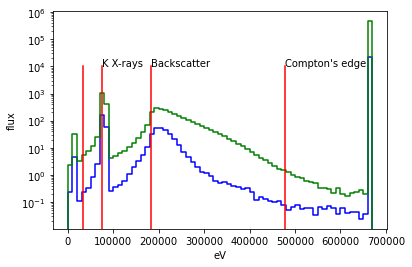

In [137]:
plt.plot(xEnergy,y1,'b')
plt.plot(xEnergy,y2,'g')
plt.plot([184000,184000],[0,10000],'r')
plt.plot([478000,478000],[0,10000],'r')
plt.plot([75000,75000],[0,10000],'r')
plt.plot([32200,32200],[0,10000],'r')
plt.text(184000,10500,"Backscatter")
plt.text(478000,10500,"Compton's edge")
plt.text(75000,10500,"K X-rays")
plt.yscale('log')
plt.xlabel('eV')
plt.ylabel('flux')
#plt.ylim(0,1000)
plt.savefig('backscatter_Si_Cs137_200keV.jpeg')

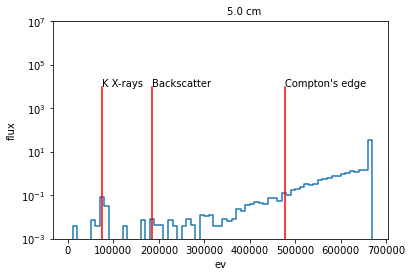

In [138]:
frames = 50  # number of frames in the animation equal number of mesh layer in z-axis
y1=0

fig, ax = plt.subplots()

y1 = np.array(np.repeat(layerSpectr[0],2))
y1 = np.insert(y1, 0, 0., axis=0) # add zero to front
y1 = np.concatenate([y1, np.zeros(1)]) # add zero at back

line, = ax.plot(xEnergy,y1)
ax.plot([184000,184000],[0,10000],'r')
ax.plot([478000,478000],[0,10000],'r')
ax.plot([75000,75000],[0,10000],'r')

ax.text(184000,10500,"Backscatter")
ax.text(478000,10500,"Compton's edge")
ax.text(75000,10500,"K X-rays")


label = ax.text(3.5e5, 2e7, str(0.0)+' cm', fontsize=10)
ax.set_yscale('log')
ax.set_ylim(0.001,1e7)
ax.set_xlabel('ev')
ax.set_ylabel('flux')

y1=0

def animate(i):
        
    y1 = np.array(np.repeat(layerSpectr[i],2))
    y1 = np.insert(y1, 0, 0., axis=0)
    y1 = np.concatenate([y1, np.zeros(1)])
    
    line.set_ydata(y1)  # update the data.
    label.set_text(str((i+1)/10)+' cm')
    
    y1=0


anim = animation.FuncAnimation(fig, animate, frames=frames,interval=500)#, blit=True)
anim.save('Cs137_Pbspectrum.gif', writer='imagemagick')

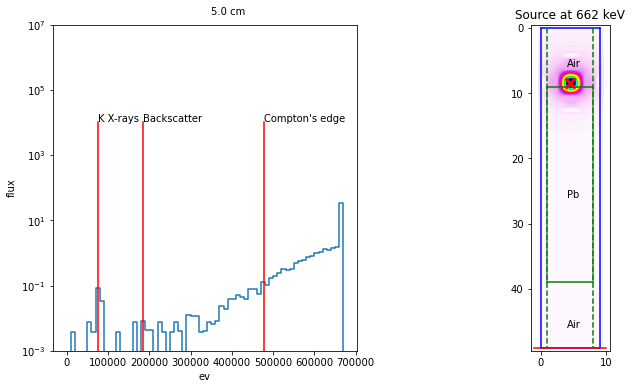

In [140]:
frames = 50  # number of frames in the animation equal number of mesh layer in z-axis
y1=0

fig = plt.figure(figsize=(12, 6))

#fig, ax = plt.subplots(1, 4)

ax = fig.add_subplot(1, 2, 1)

y1 = np.array(np.repeat(layerSpectr[0],2))
y1 = np.insert(y1, 0, 0., axis=0) # add zero to front
y1 = np.concatenate([y1, np.zeros(1)]) # add zero at back

line, = ax.plot(xEnergy,y1)
ax.plot([184000,184000],[0,10000],'r')
ax.plot([478000,478000],[0,10000],'r')
ax.plot([75000,75000],[0,10000],'r')

ax.text(184000,10500,"Backscatter")
ax.text(478000,10500,"Compton's edge")
ax.text(75000,10500,"K X-rays")

label = ax.text(3.5e5, 2e7, str(0.0)+' cm', fontsize=10)
ax.set_yscale('log')
ax.set_ylim(0.001,1e7)
ax.set_xlabel('ev')
ax.set_ylabel('flux')

#--------------------geometry--------------------
ax0 = fig.add_subplot(1, 2, 2)

ax0.title.set_text('Source at 662 keV')
source = ax0.imshow((chDataFrameMean['67.0'][:,:,4]),
                      cmap='gist_ncar_r',interpolation='bessel');
ax0.plot([1,8],[9,9],'g')
ax0.plot([1,8],[39,39],'g')
ax0.plot([1,1],[9,39],'g', alpha=0.75)
ax0.plot([8,8],[9,39],'g', alpha=0.75)

ax0.plot([0,9],[0,0],'b')
ax0.plot([0,9],[49,49],'b')
ax0.plot([0,0],[0,49],'b')
ax0.plot([9,9],[0,49],'b')

ax0.plot([1,1],[0,49],'g--')
ax0.plot([8,8],[0,49],'g--')

ax0.plot([4.5],[8.5],'rx',ms=10,markeredgewidth=3)

ax0.text(4,26,"Pb")
ax0.text(4,6,"Air")
ax0.text(4,46,"Air")

line2, = ax0.plot([-1,10],[0,0],'r')


y1=0

def animate(i):
        
    y1 = np.array(np.repeat(layerSpectr[i],2))
    y1 = np.insert(y1, 0, 0., axis=0)
    y1 = np.concatenate([y1, np.zeros(1)])
    
    line.set_ydata(y1)  # update the data.
    line2.set_ydata([i,i])
    label.set_text(str((i+1)/10)+' cm')
    
    y1=0


anim = animation.FuncAnimation(fig, animate, frames=frames,interval=500)#, blit=True)
anim.save('Cs137_Pb_Geo_spectrum.gif', writer='imagemagick')

In [46]:
layerSpectr.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

Ref: https://physicsopenlab.org/2016/02/04/compton-scattering-2/

In [47]:
Cs68 = []
for i,j in enumerate(layerSpectr):
    # print (layerSpectr[j][-1])
    Cs68 = Cs68 + [layerSpectr[j][-1]]

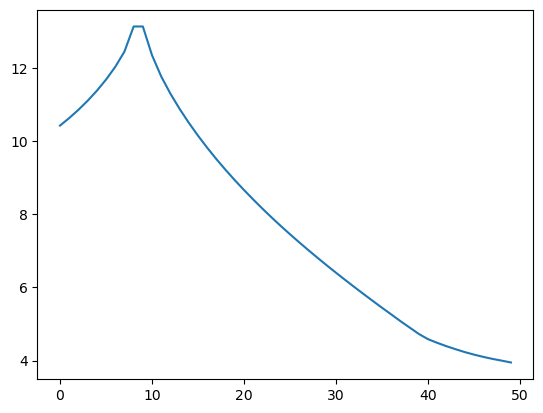

In [48]:
plt.plot(np.log(Cs68))